In [1]:
# https://github.com/Elucidation/tensorflow_chessbot/blob/master/tensorflow_generate_training_data.ipynb
# https://github.com/Elucidation/tensorflow_chessbot/tree/master
# https://github.com/dimasikson/chess_computer_vision_project
import numpy as np
from selenium import webdriver
import PIL
from IPython.display import  Image, display
from PIL import ImageDraw
import torch
import sklearn
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('ggplot')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Project Overview

This project revolves around transforming a screenshot of a chess board into Forsyth-Edwards Notation (FEN). The central strategy is to employ an object detection model, specifically YOLOv5, to pinpoint the chess pieces on the board and their respective positions.

The project pipeline includes these essential steps:

1. **Image Generation:** This phase consists of capturing and saving screenshots of various chess board positions, which serve as the raw input data for the subsequent stages.

2. **Image Processing:** After generation, images undergo transformations such as cropping and resizing to make them suitable for the machine learning model. The goal here is to ensure the images fit the model's requirements and any irrelevant details are excluded.

3. **Label Generation:** For each processed image, bounding box labels are generated, indicating the positions and types of chess pieces. These labels are the ground truth during the training of the object detection model.

4. **Data Split:** The processed images and their associated labels are then split into distinct training, validation, and testing sets, a key step in machine learning to ensure the model can generalize well to unseen data.

5. **Object Detection:** Here, the YOLOv5 model is employed to detect chess pieces on the board. This phase involves training the model on our training set and validating its performance on the validation set.

6. **Model Evaluation:** After training, the model's performance is evaluated on the testing set, giving an unbiased estimation of its performance and ability to generalize to unseen data.

7. **FEN Generation:** Once the pieces and their locations have been identified, the final step is to convert this information into FEN.

FEN (Forsyth-Edwards Notation) is a standard notation for describing a specific board position of a chess game. FEN captures all the necessary information to restart a game from a particular position, including the placement of pieces on the board, the player's turn, castling availability, en passant target square, half-move clock, and full-move number.

A typical FEN record looks like this: "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1".

- The first part ("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR") represents the positions of the pieces on the board. Each letter represents a piece (lowercase for black, uppercase for white). The numbers represent empty spaces.

- The second part ("w") denotes who's turn it is. "w" for white and "b" for black.

- The third part ("KQkq") indicates the availability of castling. Each character represents the king or queen-side rook of white ("KQ") or black ("kq"). If a character is missing, that means the respective castling is not possible.

- The fourth part ("-") shows the en passant target square. If there is no en passant target square, this is marked as "-".

- The fifth part ("0") is the half-move clock. It represents the number of half-moves (or turns) since the last pawn advance or capture. This is relevant for determining the possibility of a draw.

- The sixth part ("1") is the full-move number. It indicates the number of the full moves completed, where one full move consists of a turn by each player.

The project outcome will be a program capable of generating accurate FEN strings given an image of a chess board. Such a tool can greatly aid in digitizing physical chess games, analyzing historical games and more.


The project is inspired by the following repository: https://github.com/Elucidation/tensorflow_chessbot/tree/master, which does not use object detection but rather detects each tile of the board, splits the image and passes it through a cnn.


First is the FEN string generation. The function `getRandomFEN` generates a random Forsyth-Edwards Notation (FEN) string representing a chess board configuration. The function randomly chooses characters from a set representing all possible chess pieces and empty spaces ('1', 'K', 'Q', 'R', 'B', 'N', 'P', 'k', 'q', 'r', 'b', 'n', 'p') to form a 64-character string that maps to the 64 squares on a chess board. The characters 'K', 'Q', 'R', 'B', 'N', and 'P' represent the white king, queen, rook, bishop, knight, and pawn respectively. Lowercase equivalents represent the corresponding black pieces. The '1' character represents an empty square on the board.

This function takes two parameters, `rand` and `rand2`, which allow us to modify the number of '1' (empty squares) and 'Pp' (white and black pawns) characters in our FEN string respectively. The default value of these parameters is 0. Increasing the value of `rand` or `rand2` increases the likelihood of generating empty squares or pawns respectively.

The resulting string by no means represents an allowed configuration on a chess board. However, by having crowded boards we can train the model on fewer images and also force the model to generalize on all positions. Otherwise, the data would be biased towards e.g. the starting position. The idea behind upsampling empty spaces and pawns is that they are usually overrepresented compared to the other pieces, such that a small bias might be useful.

In an extra step we could see how our model performs on real historic chessboard settings. Possible sources:

Historic games https://wtharvey.com
https://chess.stackexchange.com/questions/19633/chess-problem-database-with-pgn-or-fen

In [2]:

def getRandomFEN(rand=0, rand2=0):
    fen_chars = list('1KQRBNPkqrbnp'+'1'*rand+'Pp'*rand2)
    pieces = np.random.choice(fen_chars, 64)
    fen = '/'.join([''.join(pieces[i*8:(i+1)*8]) for i in range(8)])
    # can append ' w' or ' b' for white/black to play, defaults to white
    return fen

fen = getRandomFEN(rand=4)
print (fen + ' w KQkq - 0 1')
print (fen.replace('/','-'))

nPQP1nkp/k11Kk1Kp/rRKbKnR1/k1kkKRq1/KkBbbpQk/pnRK1nrb/1bqrR1N1/PNNq1qQq w KQkq - 0 1
nPQP1nkp-k11Kk1Kp-rRKbKnR1-k1kkKRq1-KkBbbpQk-pnRK1nrb-1bqrR1N1-PNNq1qQq


In [3]:
# simple class encodings, we differentiate between black and white even for the empty tiles
# in the prediction of a chess configuration that differentiation is not necessary

classes= {"empty_white":0,
"empty_black":1,
"black_pawn":2,
"black_rook":3,
"black_knight":4,
"black_bishop":5,
"black_queen":6,
"black_king":7,
"white_pawn":8,
"white_rook":9,
"white_knight":10,
"white_bishop":11,
"white_queen":12,
"white_king":13
}

inv_cl = { v:k for k,v in classes.items()}

# The mapping
fen_to_class = {
    'P': 8, 'R': 9, 'N': 10, 'B': 11, 'Q': 12, 'K': 13,
    'p': 2, 'r': 3, 'n': 4, 'b': 5, 'q': 6, 'k': 7,
    '/': '\n', # new line for each rank
}

# Decide the color of the empty square based on its position
def get_empty_class(rank_index, file_index):
    return 0 if (rank_index + file_index) % 2 == 0 else 1


Data for this project was generated using the online chess server Lichess. Lichess offers a RESTful API that can render a chess board in a specified Forsyth-Edwards Notation (FEN) configuration. By using the endpoint `https://lichess.org/editor/<FEN-STRING>`, we can load a page with a chess board in the configuration described by the FEN string. 


In [4]:
from selenium import webdriver

driver = webdriver.Chrome()
fen = getRandomFEN()
url = "http://en.lichess.org/editor/%s" %fen
output_filename = "testA.png"

driver.get(url)

driver.save_screenshot(output_filename)

driver.quit()

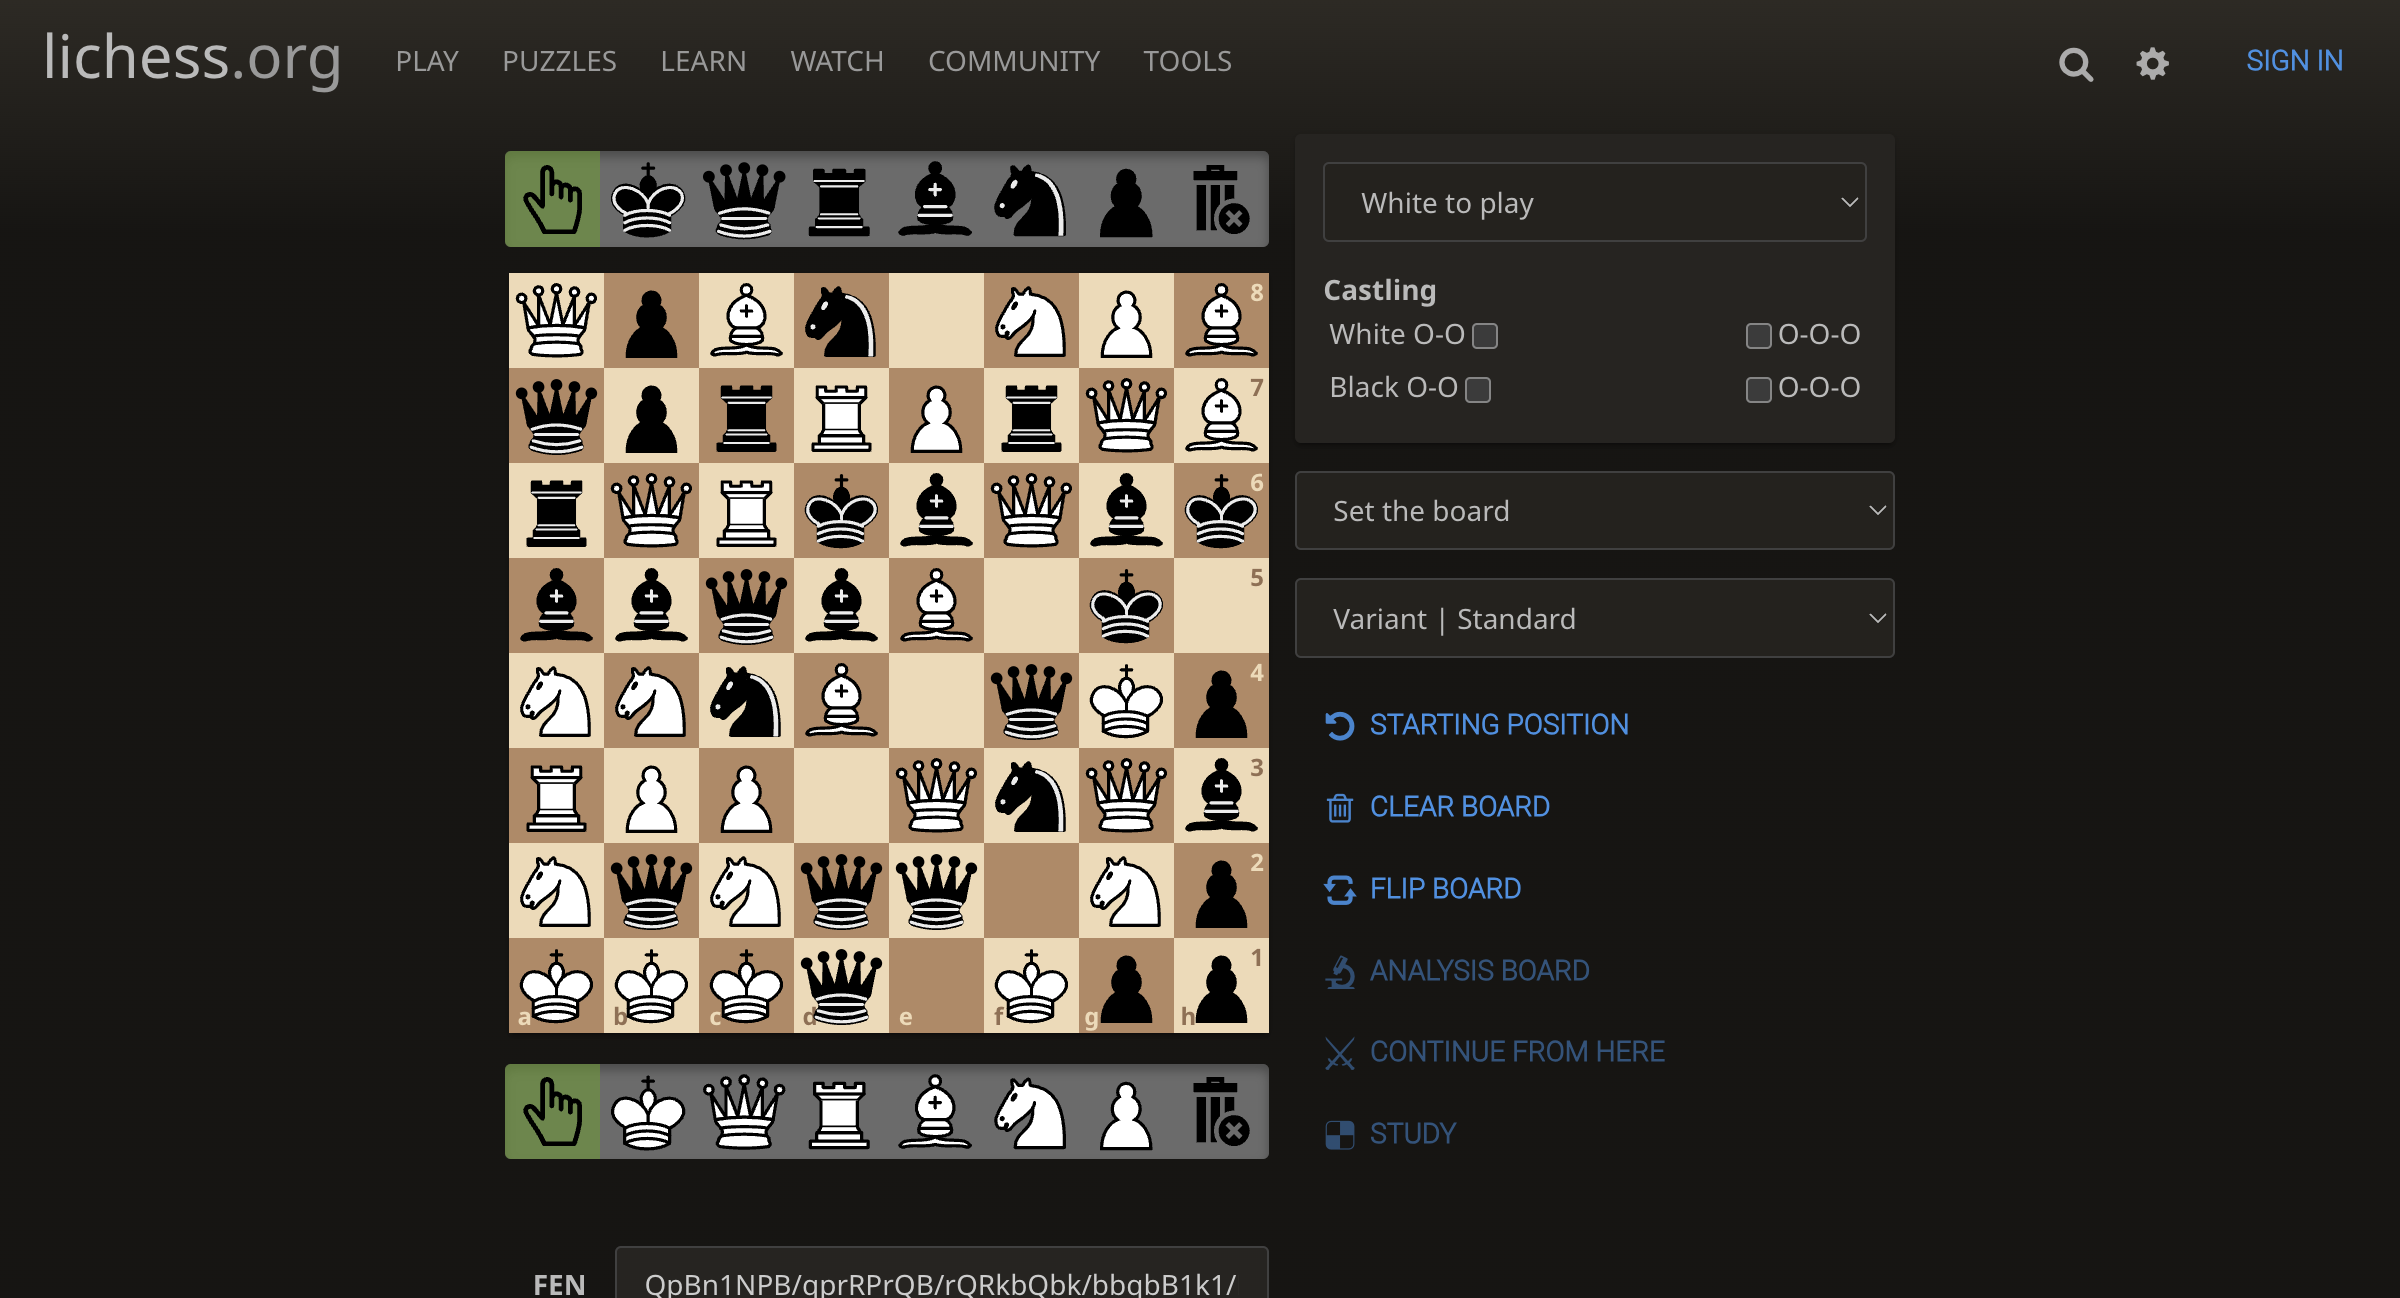

In [5]:
display(Image("testA.png"))

Lichess provides various board themes and figure (piece) styles to enhance the diversity of our generated dataset. To include these in our data generation process, we need to pass a specific cookie. Extracting this cookie from the Lichess website is a rather tedious task.

Please note, the cookies used here might not work for everyone due to individual browser settings, cookies and Lichess account preferences. In this project, we have utilized 14 different board themes and 9 different figure styles to generate our images, although Lichess offers many more options.

Utilizing a variety of board themes and figure styles during data generation provides more variability in our dataset, which can help improve the robustness and generalization ability of our trained model. The model will learn to recognize chess pieces across a variety of visual representations, increasing its ability to accurately interpret new, unseen images.

In [6]:
cookies ={
                'canvas_cburnett':'b5a8a9f92f06bffb2ce2ec2337187a9d5699321a-sid=qPFitnqJ9jE2y1CeYqXpTX&theme=canvas',
                'blue_cburnett':'4e8a6d738c60472f7f025b164ab7db916e2d76a1-sid=4yVm6Mp6uuQw7YuLhurXXl&theme=blue&pieceSet=cburnett',
                'blue_marble_cburnett': '5b17604f54c424a533957a9f6604010b966b1efb-sid=l1HNamCFbRSQoGqKNzE8rw&theme=blue-marble&pieceSet=cburnett',
                'blue3_cburnett': 'b1821e5dee8cedee0c73644bffc6758b1d60fa41-sid=ZLOvL2Y6UTzk2eFriqsKlD&theme=blue3&pieceSet=cburnett',
                'wood_cburnett': '7414207ee10ef9061dde782fb2b823f5ef1086b7-sid=39obY88OC2zyofCr6dqSOQ&theme=wood&pieceSet=cburnett',
                'wood2_cburnett': '76ffd1acff502dfc787f339e7f1ee0be62c71917-sid=2BPpmQ6I10VyrzU98mvbSQ&theme=wood2&pieceSet=cburnett',
                'maple_cburnett': '677089d5e0c1908235a7cad693e37ebf65d0dda6-sid=zedOUpH4WZpQY44omqOZo9&theme=maple&pieceSet=cburnett',
                'brown_cburnett': '5f2e718a0b14186ffcfa373dc0a261f13fb139ce-sid=elHmDpqO9WEvc9fO2ZFGgA&theme=brown&pieceSet=cburnett',
                'metal_cburnett':'4895544c392928195add98e28274268eab752967-sid=JS9I89rsyAySsR6d1pUQEZ&theme=metal',
                'grey_cburnett':'e2d86881a61b656390b2c2975bcd36f77db81dee-sid=70A6mbcV7BUrqb3PAT1mRd&theme=grey&pieceSet=cburnett',
                'olive_cburnett': '59d33efd0ca120f25c4d4862ba91e66d766b7ae9-sid=s5reiu77BwZoltz37hcMLp&theme=olive&pieceSet=cburnett',
                'news_cburnett': '4d1975f21b7ce66a7e273564ae1de0b0c7b54983-sid=XeYoTQ5vEAdbeNYt6z4Vh9&theme=newspaper&pieceSet=cburne',
                'leather_cburnett': '74bd53e0e947ac0e0f859ce53bff29e9b4986848-sid=JfEQNJVwLuNumZnhVDB4li&theme=leather&pieceSet=cburnett',
                'horsey_cburnett' : 'fc5dcffdfb2d2acbc0698dc5be70e6af16362aba-sid=qq9miZd1qmK83g2hHsFShz&theme=horsey&pieceSet=cburnett',

                'brown_merida': '2bb7ce42f50fdcc1f06931cdd2cc29911af23558-sid=fDz9CiPEDlAjY9DgbDI5nj&theme=brown&pieceSet=merida',
                'brown_alpha': '34cafbf823a5b4dd8a06d819529e58ea73c4ccab-sid=3U97LYccnqlsHELPOSHWhX&theme=brown&pieceSet=alpha',
                'brown_chestnut': '1b744e1fb1fcf7a1740c78dd787685bf59817cfa-sid=cq7n9j8lVyeD28eOArXxPH&theme=brown&pieceSet=chessnut',
                'brown_chess7': 'e3ac4f6e36ba77df2e20cd3a7cd09092a0c96e04-sid=QkpbAchT922z0fTjSOXFhO&theme=brown&pieceSet=chess7',
                'brown_reily': '62dd68922fadde9a560b3a6816e76a1a67e737df-sid=zBblOKlB5ASLKHYW6i8kru&theme=brown&pieceSet=reillycraig',
                'brown_kosal': '7c6349b4b963eb4a4ab55cc6af7037da7e213686-sid=eNq9pFCcLljeq14VAcnXmF&theme=brown&pieceSet=kosal',
                'brown_fantasy': '8e7bd8a53829a8c0ba757b07dab5a08ef05466b6-sid=Otsk1r5aDRKCPYkk64q1AG&theme=brown&pieceSet=fantasy',
                'brown_celtic': '758f7880d78db7995bddee12383cdc4632f8a3be-sid=2aUuwoDuOiTHUz55lzXG8r&theme=brown&pieceSet=celtic',

                'canvas_merida': '26146646fe7da06d438d015c7939c2fe41e9ed1b-sid=mwpfxHvKR2dYC77ELzp4xT&theme=canvas&pieceSet=merida',
                'canvas_alpha': '416e37b99aec52a790fc5fd64f6031a467a763bd-sid=3XHotWBiqGe0IOlBBZ9yCq&theme=canvas&pieceSet=alpha',
                'canvas_chestnut': '4fa095f913467a8964f6d26c87396c125d95e7b3-sid=1ylPvepQ0o944gorgsQn5n&theme=canvas&pieceSet=chessnut',
                'canvas_chess7': 'b14ecaef28edbc811c1a86e9483552601be468c4-sid=gGMBRMQSUv60LvDKJzyUKN&theme=canvas&pieceSet=chess7',
                'canvas_reily': '12c31cc87d81005a8964e40fcd8dcf08af7ed5e0-sid=KopqnosxZV2DPOrJFc5YBY&theme=canvas&pieceSet=reillycraig',
                'canvas_kosal': '1c0ca883ae345e11c6b6f6a1db5210f23bc1b807-sid=mGfaIkokJwwmUXrVIgd2xy&theme=canvas&pieceSet=kosal',
                'canvas_fantasy': '043c53ea12d652886d681263d4c7666130688804-sid=bTG0VwwkT8xPssu9COe0MO&theme=canvas&pieceSet=fantasy',
                'canvas_celtic': '2ab1309ae4787c7b9218e6f605c331bde08d1f6f-sid=KDuuw29W5joKu0Qx2T4cqn&theme=canvas&pieceSet=celtic',

                'blue_marble_merida': 'ef1dd2f37ecb392c82af6680bff2f03b2cbb7569-sid=5RHozpmAeRzDxNsSKjfSYY&theme=blue-marble&pieceSet=merida',
                'blue_marble_alpha': 'ad20fb3511c02a75bb74ed57ff7ffb5b0547808e-sid=f3xrzB7rKxkgSTOrl1I8L8&theme=blue-marble&pieceSet=alpha',
                'blue_marble_chestnut': 'e0a9bd71641fb0f5723ca6fc0607ab272dad7129-sid=bW6qOVRBUQApTOLjA8g1Mu&theme=blue-marble&pieceSet=chessnut',
                'blue_marble_chess7': 'c69aedef9d7495c5c6880f4c23090bb101d9b604-sid=4yLW1TwUyQThEMvLdhMO3x&theme=blue-marble&pieceSet=chess7',
                'blue_marble_reily': '880081b2e6948fe3ab25eff87476750343ad991c-sid=AZaUKkBMbQciKhMSsKpmoH&theme=blue-marble&pieceSet=reillycraig',
                'blue_marble_kosal': '17e5924e7ff1c260183a04cdfc8b0691cadddbf0-sid=mhjMPgO5Wt6WZ1UzB8u0JN&theme=blue-marble&pieceSet=kosal',
                'blue_marble_fantasy': 'f3db3a13c5a50eb9601d80472109b68f9fbba117-sid=HJyeMiB0AGmXxEiueEYv9x&theme=blue-marble&pieceSet=fantasy',
                'blue_marble_celtic': '452398492cfac60b009f1fe905dc3362e22e5bcd-sid=32v2GZsLyIRenqtbW5URQY&theme=blue-marble&pieceSet=celtic',

                'blue_merida': 'ae58f1f0332146fe57617c3331df2ed4416ab347-sid=Jl9NGGAGscaYcqQKR4ZXct&theme=blue&pieceSet=merida',
                'blue_alpha': '622ee331391a71ce8e2581bd79bf2091366f0c06-sid=cEtCnunKA0Z6bqdvSmOCbm&theme=blue&pieceSet=alpha',
                'blue_chestnut': '2297e831be4270614e5fa3ec2de93278a66605ee-sid=OQ0D5ezyMgTl8YlYA0sSXU&theme=blue&pieceSet=chessnut',
                'blue_chess7': '25f56db140395c04e952efa44af16596ac20f19c-sid=N0lazLD5WcmRxg7JdiWhaj&theme=blue&pieceSet=chess7',
                'blue_reily': '83ad740880ac58c4ff88739db8bbd184fb9400a0-sid=z1R2aHsjzVovQkGAVowR5f&theme=blue&pieceSet=reillycraig',
                'blue_kosal': '509de8d0951af0e90cabd685943a4ed27b164081-sid=t7VbrFQIuOnqpt2EYiihd5&theme=blue&pieceSet=kosal',
                'blue_fantasy': 'b16af096d9099f05c559418f6a630bd138bbc5c3-sid=o5TnK48ZpDhtdnSKJXjcBP&theme=blue&pieceSet=fantasy',
                'blue_celtic': 'c0a31735c7ab970d819d4490933147f9badb09d6-sid=ixVvsk9MRydStsNXvWRVQr&theme=blue&pieceSet=celtic',


                'blue3_merida': '4bf90f969a293d83341b8908610f0cd545a509a7-sid=hcMbPL7K9binCWTay5HOum&theme=blue3&pieceSet=merida',
                'blue3_alpha': '3087bc4520f7214b334359278e815430276daebc-sid=zPfTluQXEHPYQ3K3ul0WmZ&theme=blue3&pieceSet=alpha',
                'blue3_chestnut': 'c8e7727d01c52d25a4b85aa427201c6fff47fecd-sid=majcodaMbtUNcI4KxrzJFq&theme=blue3&pieceSet=chessnut',
                'blue3_chess7': '59695e6214d80264be0a1a2840790da1afba1cd0-sid=DK2tdGvCUPRkopFtXZOU0T&theme=blue3&pieceSet=chess7',
                'blue3_reily': '51bb690d425fa4e7ccbddb42c990d5648e810be1-sid=HlMlo7MBsTM0d0xHArX3cF&theme=blue3&pieceSet=reillycraig',
                'blue3_kosal': 'de06f412d2cb813203a2157ee52ecea72857f754-sid=z87EbcLsdaWTQhiV9QeLAZ&theme=blue3&pieceSet=kosal',
                'blue3_fantasy': '0e9bdb2547766d6df32688559615357cba7e2ce0-sid=EcccrZfZ38mPPGDauw6eDr&theme=blue3&pieceSet=fantasy',
                'blue3_celtic': '5fcaf74418ca3c673e3f1d4c23ffc56d08b5e76c-sid=mTrtX2POlwo9P8KAqXTj70&theme=blue3&pieceSet=celtic',


                'wood_merida': '3d25bbcd203389be19f84646387d0d735725175b-sid=ibmEyIA5UtPdXucQ3Ckfst&theme=wood&pieceSet=merida',
                'wood_alpha': 'd648dfe6ece2931ead529c3f0584f734ed54622e-sid=XU9wAfSWsj3f3Hgk7QcEPB&theme=wood&pieceSet=alpha',
                'wood_chestnut': '7a7590f52c554f11d0fa586ca8f022bc6c9108fb-sid=3TjSf2yEhdDEDnwgVYbR1H&theme=wood&pieceSet=chessnut',
                'wood_chess7': 'ba36f056ff50904a741d034a4e675619cac4624d-sid=QvB6jSamIQgCM3DbslZuDS&theme=wood&pieceSet=chess7',
                'wood_reily': 'b90c9a75b9a991da8d43c7f4cb17333fafd03a90-sid=yh4y67NTantmxdQehPjbA8&theme=wood&pieceSet=reillycraig',
                'wood_kosal': '1450d1f27b46f8fb7b6ce925c59f0a0c37e2641b-sid=5F77vX8VisBvqenoitOLgT&theme=wood&pieceSet=kosal',
                'wood_fantasy': 'd868d3d2d8a782c0e850d641341215df4c8e2b1c-sid=zeCDv2fKchZPqPTrwaPv0E&theme=wood&pieceSet=fantasy',
                'wood_celtic': 'e9fbc40de837cc0b4baddc79730515bf8910096d-sid=zAGQtE6cVombkgGfnknI0K&theme=wood&pieceSet=celtic',


                'wood2_merida': '102e4fcaaf444d9d987cf95b2ce2498f5cd8bf83-sid=Re8ObeekCRdbPdTSJB1R4G&theme=wood2&pieceSet=merida',
                'wood2_alpha': 'a17c675ad135e11c9a3ae302ce070396eb9dd6eb-sid=eVS7kUoF15e6aTqZpbMV7F&theme=wood2&pieceSet=alpha',
                'wood2_chestnut': '224ed1d409e95605f4267c548d3418c7ed8369ba-sid=y99LQvah3yuYVFnSCLa8xe&theme=wood2&pieceSet=chessnut',
                'wood2_chess7': '1bec520188d861d797b300d36448b1eca505451a-sid=bBT52zLIuTqcD7YwzqiktO&theme=wood2&pieceSet=chess7',
                'wood2_reily': '798badeb12553363e15d6a2dbefb54f554eac426-sid=1PPegqvnLHZ48xzf1FZ7dm&theme=wood2&pieceSet=reillycraig',
                'wood2_kosal': 'f31de4ede774b639b239e2f5a9d56379b9f83351-sid=O1kE03hFzxnOQKOH5NwRwa&theme=wood2&pieceSet=kosal',
                'wood2_fantasy': 'fbe46667be94bb058131e20af22c96bc865165af-sid=DgqmUe1uxaUiLwmEpp5Jmb&theme=wood2&pieceSet=fantasy',
                'wood2_celtic': 'a863db0c01f2d2e4a56a80e9cf3450493b0b30a6-sid=29rnibYQARAhGlutRTwzDF&theme=wood2&pieceSet=celtic',


                'maple_merida': 'f4792aec300643d08a2077c2ccc36136047dc4ea-sid=vxJzPHLex60yV0TplkKAI9&theme=maple&pieceSet=merida',
                'maple_alpha': 'b6d4bd3661f453de9cedcacbd7fa594141cf1640-sid=9xOfWhaQ1GoF5oWwFzgEHO&theme=maple&pieceSet=alpha',
                'maple_chestnut': '470ae630a36ac13fa09b0f2994b181c4e07031c0-sid=cDBKbsjyd5B4wswAggGoqo&theme=maple&pieceSet=chessnut',
                'maple_chess7': 'c2bd4748a1bb2755c8d2aef4c5f5434058bcf02b-sid=Z6wgLJnTbqORTt9myH6LMJ&theme=maple&pieceSet=chess7',
                'maple_reily': 'eaa2336bb1f42127b514b48653c5e05563285176-sid=XD627quZ1UvKwaPLR3nxqy&theme=maple&pieceSet=reillycraig',
                'maple_kosal': '918f439dd1be970fc8baf64afb30fc422af2a355-sid=J32PXozFyc09UPNucncViz&theme=maple&pieceSet=kosal',
                'maple_fantasy': '70d9a1e5b5e084541cb3c86c1552ccb27274c448-sid=mwTahKK82pHoegwqB493aC&theme=maple&pieceSet=fantasy',
                'maple_celtic': 'aba2aeccda1b53af7c4a36d6762e1807cee4ca6c-sid=lmClW53eCWiihsOIRCOos4&theme=maple&pieceSet=celtic',


                'metal_merida': '75e9b4979056d90f17dc3265a8e79b1fb042c49a-sid=frttJU4C2x7Yt3f249i38M&theme=metal&pieceSet=merida',
                'metal_alpha': 'ff1c0d14f269969a1a098a6a602f54b68f5ea31f-sid=xPR76EHCTdBsLg4l7meVCP&theme=metal&pieceSet=alpha',
                'metal_chestnut': 'cca4402354faba8b2efd1fc527839db892d4979f-sid=AwQYlH2Y8ygvTLsTQ9HnpM&theme=metal&pieceSet=chessnut',
                'metal_chess7': '070628a159d1bc1962030316803ae7a9c2cad375-sid=UuDwXHnG8h7XZeYBQBYolr&theme=metal&pieceSet=chess7',
                'metal_reily': '1492c311d0a8f1e87438c04eb2246043c4b4ebb0-sid=LqtAx7Zw3e9Aa3lLM0grs9&theme=metal&pieceSet=reillycraig',
                'metal_kosal': '6421e34c518a8b2304cc77b742fefe6dbaf2a2a4-sid=nTGRyIBJ0kBjDqwFTHUpkd&theme=metal&pieceSet=kosal',
                'metal_fantasy': '74156764c4e1e14caf48bbc8fbde01c8721d1caf-sid=DQjNgGoEtyVlchZHKIOVS9&theme=metal&pieceSet=fantasy',
                'metal_celtic': '720d4781258488a2464e8645f9357d5a7f2f36eb-sid=vFj8398m42qWNSRqgnDE48&theme=metal&pieceSet=celtic',


                'grey_merida': 'c8eabca9aee70a347d97440ee1fd6aede437f245-sid=ogAWmtAHxBV2q34Ecc8WBN&theme=grey&pieceSet=merida',
                'grey_alpha': 'a6f2b04dbeb4fad21db88dad7d8d47479908cc13-sid=TrhnMMpuAOUO9YIOXpme16&theme=grey&pieceSet=alpha',
                'grey_chestnut': 'c0ffa9cb3d18cc81b1ddf52bd162d82fcd388a3c-sid=GxfL204TtB02b68NsEGkHs&theme=grey&pieceSet=chessnut',
                'grey_chess7': '10ff65e65e946f91c7507ae5e9716641c33b51ef-sid=iwXV5IdXSTtef1Cgt9zhR1&theme=grey&pieceSet=chess7',
                'grey_reily': 'a2979e368e55483c5d450e1c47037c59f80f11e2-sid=HPaRolEvfyDoHmifVPJczx&theme=grey&pieceSet=reillycraig',
                'grey_kosal': '093593b5752074bef28dd1c7231d236559b66780-sid=U4be63ACnm9Xbue0Jib4Ji&theme=grey&pieceSet=kosal',
                'grey_fantasy': '3df40d0a6831404d13a900718d6fe9370f5d0716-sid=SA3Xh43wVAzdVQmXtxVw9T&theme=grey&pieceSet=fantasy',
                'grey_celtic': 'ae4d17b9150454624f125ce0041e7ddcb87b70d6-sid=H9IXvmtgYBanpxwFz5pRmZ&theme=grey&pieceSet=celtic',


                'olive_merida': 'b70a4021a4b1aefd137ce26e5f73699037410745-sid=Ui9W9pT4VhbBvGy3UlXgOz&theme=olive&pieceSet=merida',
                'olive_alpha': 'ddb55063b48e192dfcd691a5578fb698cbe54817-sid=BqhQ5edNjOSkN1CDiN71oT&theme=olive&pieceSet=alpha',
                'olive_chestnut': 'eb54064062c3dc195a47a89ae99250f1b5087aed-sid=bFEQ1tMBKljwD3NLd1BMs4&theme=olive&pieceSet=chessnut',
                'olive_chess7': '66150e0dfbfedb05763a716896b9ee99ce162f0c-sid=Fh2eGyoGRxoBRWh7HrkseY&theme=olive&pieceSet=chess7',
                'olive_reily': '4200bb9fcda3016757a8cb2cabf81e7cad8da4f0-sid=lVYPkSCx97xW1Ss7S1Xa2I&theme=olive&pieceSet=reillycraig',
                'olive_kosal': '4eb625bc957baf7a5e516c225134a788577e36ba-sid=L1sjFl1SkefsJeulqk8uDi&theme=olive&pieceSet=kosal',
                'olive_fantasy': 'f26ad5ed7460209690dbec70a3adea521f39caca-sid=WmwOyVVa2RGqfOPOAbTE5f&theme=olive&pieceSet=fantasy',
                'olive_celtic': '7ce2d7d9067cfa43d46f3ba3944689507081231c-sid=XZ4VYKBrKEXUJBdB33c737&theme=olive&pieceSet=celtic',

                'news_merida': '118486cfcd22d16eee4bb37e376d523800def6ed-sid=YlzRV8OORozqTVxvfZTZjG&theme=newspaper&pieceSet=merida',
                'news_alpha': 'a450eaf2348a5dbb742ba31750bfcb779f7e9796-sid=hIKNo0NfRbYOITah5OBndg&theme=newspaper&pieceSet=alpha',
                'news_chestnut': 'ea025d51bc36f82a1e81bf2be54766bc44418e1e-sid=O63VqU4vYaVXBEsLGMb7LX&theme=newspaper&pieceSet=chessnut',
                'news_chess7': '819a661f695f714df6cc90f28c3e839eb99bae9b-sid=s1Nnlh5vzUVt3gysMzf8wJ&theme=newspaper&pieceSet=chess7',
                'news_reily': 'ad9221ca010e36a2ff7d08bfafce2ff27c28b65c-sid=Y9OogU5De4DSWN67eLJ7xh&theme=newspaper&pieceSet=reillycraig',
                'news_kosal': 'd943487d6b06018c6b8e420705703c8dbf16cb35-sid=s5fiqTtxoGK7kSq4nyHZWZ&theme=newspaper&pieceSet=kosal',
                'news_fantasy': 'dcb40ddeb876e4b59cce32262ffc3fcb1b548495-sid=cAKiGDh5zYZfLFKHWGe5Zz&theme=newspaper&pieceSet=fantasy',
                'news_celtic': 'e9f605adfc8494bd0c6ab8c878846768da56439b-sid=lwAEQWsgBRMIuWbfKRxm2B&theme=newspaper&pieceSet=celtic',

                'leather_merida': 'ba85445b3a83e6deeadadb89af7f7d9f840c6a89-sid=7UWMPwbDNzqztI6FgsV6tO&theme=leather&pieceSet=merida',
                'leather_alpha': '8eed0f43f627cec3675d2c3f11fcdcaf526b4392-sid=xVqV2ftDTtzBT9aoqevIQY&theme=leather&pieceSet=alpha',
                'leather_chestnut': '929379cd7d152a9f1c03855d547402e8de13e42f-sid=MNvstE2FsHqeFyELQPVuC1&theme=leather&pieceSet=chessnut',
                'leather_chess7': '9bcddce639ecc9bd0f564ab9f8c9e28ccde03cd9-sid=bxCQymzCuAm0VAQoM4ZFmW&theme=leather&pieceSet=chess7',
                'leather_reily': '0f12f89a6d33312c3cc0b79a773d1dbbf7dfcd12-sid=KHTIiIUBkPnOJKHEPEx7lu&theme=leather&pieceSet=reillycraig',
                'leather_kosal': 'ea7cbe11e4d2bf7c2d5315faa276ef9431864b72-sid=WlZjbOCSl794kYXBdIsDA8&theme=leather&pieceSet=kosal',
                'leather_fantasy': '863b6fb1916fffb1f834c2abf92db6e90b21796b-sid=PsSUIhsuiaQY03eQ1FPu6G&theme=leather&pieceSet=fantasy',
                'leather_celtic': '900cc139d061cabee9e7952d22efda7e35e15387-sid=PALRQLdcQ5jVJUx9Dieedy&theme=leather&pieceSet=celtic',

                'horsey_merida': '6cc0cea3619e81ebbd4f673b252216784d52aff3-sid=36DhdYdG5tbhgBSUVwYmB0&theme=horsey&pieceSet=merida',
                'horsey_alpha': '696d36f908f947cd01291455e4a5be09f146edca-sid=aN80F8YHeJEz0vgUAppYsu&theme=horsey&pieceSet=alpha',
                'horsey_chestnut': '9439ec923f3c06fb399949543fcada09020bb1dc-sid=axyy0BKvbPT0MJD7oNr3ZJ&theme=horsey&pieceSet=chessnut',
                'horsey_chess7': '0e4c46c45f4f8a91a2bb282b870670bd7019a071-sid=GvdagL61Z5kTnReVL5mmri&theme=horsey&pieceSet=chess7',
                'horsey_reily': '533eed458cbbe98be1dcb7d7a09dd86dfd57d4ea-sid=nMOPN4OC9x3ACNx90SCR1W&theme=horsey&pieceSet=reillycraig',
                'horsey_kosal': 'f2e0ad5903001d22528b356999db82b8dde7be5d-sid=vAsEip7QeR2xN8DedpE0lF&theme=horsey&pieceSet=kosal',
                'horsey_fantasy': '27269d4b8e4eb3f68d4710a37f303dffdc626607-sid=fRUUVvHg8fniaryUsAJkmd&theme=horsey&pieceSet=fantasy',
                'horsey_celtic': 'a69fa6f591b49bdc9c17146be8a7079f8c82e2cf-sid=jOUuoslGnMjbZMpMn2Z2xt&theme=horsey&pieceSet=celtic'

                }

In [27]:
#empty board
empty_fen = '8/8/8/8/8/8/8/8'

driver = webdriver.Chrome()
url = "http://en.lichess.org/editor/%s" %empty_fen
output_filename = "empty.png"

driver.get(url)

driver.save_screenshot(output_filename)

driver.quit()

In [ ]:
#preprocessing_screenshot("empty.png", fen, size=640,x=0.067)

Sine we are having the same screenshot everytime and we know the configuration of the board we can easily preprocess the data in such way that it is compatible to a YOLO framework. This annotation uses the same grid of bounding boxes for each image and regardless of the figure the bounding box is always the same. In further iterations one could use more specific bounding boxes depending on the exact figure.

In [7]:
def preprocessing_screenshot (image, fen, size=640, x=0.067, y=0.065, width=0.1125, shiftx=0.1241, shifty=0.1241, filename=None, inpaint=False):
    """
    This function processes a screenshot of a chess board and optionally generates bounding box labels for the chess pieces on the board. 

    Parameters:
    image (str): Path to the image file.
    fen (str): The FEN string corresponding to the image.
    size (int, optional): Size to which the image will be resized. Default is 640.
    x, y, width, shiftx, shifty (float, optional): Parameters for defining the bounding boxes. They are all proportions of the image size and are set to default values that work well for our specific setup.
    filename (str, optional): Name of the file to which the bounding box labels will be written and the processed image will be saved. If this is None, the function either displays the image with drawn bounding boxes or raises an error, depending on the value of the 'inpaint' parameter.
    inpaint (bool, optional): If this is True and 'filename' is None, the function displays the image with bounding boxes drawn. If this is True and 'filename' is not None, the function raises an error. If this is False and 'filename' is None, the function raises an error. If this is False and 'filename' is not None, the function writes the bounding box labels to a file and saves the processed image.

    Returns:
    None

    Raises:
    Error: If 'inpaint' is True and 'filename' is not None.
    Error: If 'inpaint' is False and 'filename' is None.

    Note:
    The function writes the bounding box labels in a format suitable for YOLOv5: <class> <x_center> <y_center> <width> <height>, where <class> is an integer class label, and the other four values are proportions of the image width and height. Each bounding box is written on a new line.
    """
    im = PIL.Image.open(image)
    im = im.crop([505,270,1275,1040])
    im = im.resize([size,size])

    if filename==None and inpaint==True:
        draw = ImageDraw.Draw(im)
        for i in range(8):
            for j in range(8):
                xb, yb, widthb, heightb = (x+shiftx*i)*size, (y+shifty*j)*size, width*size, width*size

                x1, y1 = xb-widthb/2, yb-widthb/2
                x2, y2 = xb + widthb/2, yb + heightb/2

                # Draw the bounding box rectangle
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        im.show()

    elif filename!=None and inpaint==True:
        print("Not Possible!") # TODO: Raise error here?

    elif filename==None and inpaint==False:
        print("Not Possible!") # TODO: Raise error here?
    
    else:
        fen = fen.split(' ')[0]

        with open('Data/labels/'+filename+'.txt', 'w') as f:
            rank_index = 0
            char_index = 0
            output = "%d %f %f %f %f"
            for char in fen:
                xb, yb, width, height = (x+0.12415*char_index), (y+0.1241*rank_index), width, width
                if char in fen_to_class:
                    if char == '/':
                        rank_index += 1
                        #f.write(fen_to_class[char]) # Go to next line for next rank
                        char_index = 0
                    else:
                        
                        f.write(output%(fen_to_class[char],xb,yb,width,height) + '\n') # Write the class of the piece
                        char_index+=1
                else: # it's a number, indicating empty squares
                    for _ in range(int(char)):
                        f.write(output%(get_empty_class(rank_index, char_index),xb,yb,width,height) + '\n') # Write the class of the empty square
                        char_index+=1
        im.save('Data/images/'+filename+'.png')
        #display(Image("testA_crop.png"))

In [8]:
preprocessing_screenshot("testA.png", fen, size=640,x=0.067, filename="testA_crop") # TODO: Removed the file extension here

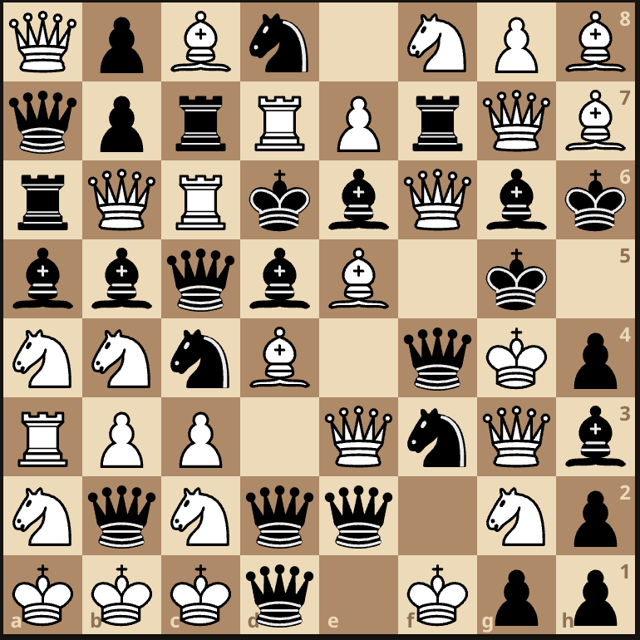

In [10]:
display(Image("Data/images/testA_crop.png"))

In [11]:
def generate_Data(N,size=640,x=0.062):
    """
    This function generates data by taking screenshots of randomly generated chess board configurations on the Lichess website and applies preprocessing to the images.

    Parameters:
    N (int): The number of data samples to be generated.
    size (int, optional): The size to which the screenshot will be resized during preprocessing. Default is 640.
    x (float, optional): A parameter used in the preprocessing function for defining the bounding boxes. Default is 0.062.

    Returns:
    result_dict (dict): A dictionary where the keys are filenames of the generated images and the values are dictionaries containing the corresponding FEN string, board theme, and figure style.

    Note:
    The function uses the Selenium WebDriver to load the Lichess webpage, add the necessary cookies to set the board theme and figure style, and take a screenshot. The screenshots are then preprocessed, and the processed images and bounding box labels are saved to the specified filepaths.
    """
    result_dict = {}
    driver = webdriver.Chrome()
    for i in range(N):
        for k,v in cookies.items():
            j =random.randint(0,3)
            j2 = np.random.choice([0,1],size=1,p=[0.75,0.25])[0]
            fen = getRandomFEN(rand=j, rand2=j2)
            theme, figure = k.rsplit('_',1)
            url = "http://en.lichess.org/editor/%s" %fen
            output_filename = str(hash(fen))
            result_dict[output_filename] = {'fen':fen, 'theme': theme, 'figure': figure}
            output_image = 'Data/raw/'+output_filename+'.png'

            driver.get(url)
            driver.add_cookie({'name':'lila2', 'value':v})
            driver.refresh()

            driver.save_screenshot(output_image)

            preprocessing_screenshot(output_image, fen,size=size,x=x, filename=output_filename)
    driver.quit()

    return result_dict


        

In [12]:
result_dict = generate_Data(16, x=0.067)

In [16]:
len(cookies)*16

2016

In [14]:
# import json
# with open ('Data/original_data.json', 'w') as handle:
#     json.dump(result_dict, handle)


In [15]:
# with open ('Data/original_data.json', 'r') as handle:
#     result_dict = json.load(handle)

In [66]:
def visualize_distribution(data_dict):
    themes = []
    figures = []

    for image_id, image_data in data_dict.items():
        themes.append(image_data['theme'])
        figures.append(image_data['figure'])

    unique_themes = list(set(themes))
    unique_figures = list(set(figures))

    theme_counts = [themes.count(theme) for theme in unique_themes]
    figure_counts = [figures.count(figure) for figure in unique_figures]

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Plot distribution of themes
    ax[0].bar(unique_themes, theme_counts)
    ax[0].set_xlabel('Theme')
    ax[0].set_ylabel('Count')
    ax[0].set_title('Distribution of Themes')

    # Plot distribution of figures
    ax[1].bar(unique_figures, figure_counts)
    ax[1].set_xlabel('Figure')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Distribution of Figures')

    plt.tight_layout()
    plt.show()

In [13]:
# visualize_distribution(result_dict)

In [16]:
# The generated data is split into train, val, test set and is modified to the structure as required by the YOLO
# Framework. 

data_dir = 'Data'
final_dir = 'custom_data'
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

train_dir_img = os.path.join(final_dir, 'images/train')
test_dir_img = os.path.join(final_dir, 'images/test')
valid_dir_img = os.path.join(final_dir, 'images/val')

os.makedirs(train_dir_img, exist_ok=True)
os.makedirs(test_dir_img, exist_ok=True)
os.makedirs(valid_dir_img, exist_ok=True)


train_dir_lab = os.path.join(final_dir, 'labels/train')
test_dir_lab = os.path.join(final_dir, 'labels/test')
valid_dir_lab = os.path.join(final_dir, 'labels/val')

os.makedirs(train_dir_lab, exist_ok=True)
os.makedirs(test_dir_lab, exist_ok=True)
os.makedirs(valid_dir_lab, exist_ok=True)


image_files = os.listdir(images_dir)
label_files = os.listdir(labels_dir)

image_files = [file for file in image_files if file.endswith('.png')]
label_files = [file for file in label_files if file.endswith('.txt')]

image_files = sorted(image_files)
label_files = sorted(label_files)


In [17]:
# Split the data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    image_files, label_files, test_size=0.3, random_state=42
)

print('Training Data: %d'%(len(train_images)))

# Split the test set further into test and validation sets
test_images, valid_images, test_labels, valid_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

print('TestData: %d'%(len(test_images)))
print('Val Data: %d'%(len(valid_images)))

# Copy train images and labels
for image_file, label_file in zip(train_images, train_labels):
    shutil.copy(os.path.join(images_dir, image_file), train_dir_img)
    shutil.copy(os.path.join(labels_dir, label_file), train_dir_lab)

# Copy test images and labels
for image_file, label_file in zip(test_images, test_labels):
    shutil.copy(os.path.join(images_dir, image_file), test_dir_img)
    shutil.copy(os.path.join(labels_dir, label_file), test_dir_lab)

# Copy validation images and labels
for image_file, label_file in zip(valid_images, valid_labels):
    shutil.copy(os.path.join(images_dir, image_file), valid_dir_img)
    shutil.copy(os.path.join(labels_dir, label_file), valid_dir_lab)

Training Data: 826
TestData: 177
Val Data: 826


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'white_queen'),
  Text(1, 0, 'white_king'),
  Text(2, 0, 'empty_white'),
  Text(3, 0, 'empty_black'),
  Text(4, 0, 'black_bishop'),
  Text(5, 0, 'black_king'),
  Text(6, 0, 'black_rook'),
  Text(7, 0, 'white_bishop'),
  Text(8, 0, 'white_pawn'),
  Text(9, 0, 'black_pawn'),
  Text(10, 0, 'black_knight'),
  Text(11, 0, 'white_knight'),
  Text(12, 0, 'white_rook'),
  Text(13, 0, 'black_queen')])

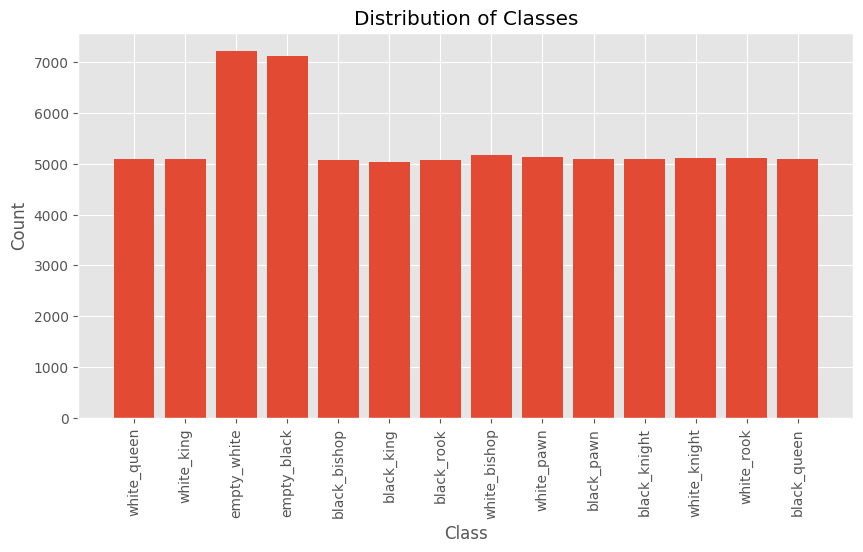

In [87]:
label_folder = 'Data/labels'

# Initialize class counts
class_counts = {}

# Iterate over the label text files
for filename in os.listdir(label_folder):
    if filename.endswith('.txt'):
        label_path = os.path.join(label_folder, filename)
        
        # Read the label text file
        with open(label_path, 'r') as file:
            lines = file.readlines()
        
        # Extract class information from each line
        for line in lines:
            class_id = int(line.split()[0])
            
            if class_id not in class_counts:
                class_counts[class_id] = 0
            
            class_counts[class_id] += 1

# Create bar plot for class distribution

labels = [inv_cl[label] for label in class_counts.keys()]


plt.figure(figsize=(10, 5))
plt.bar(labels , class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')

plt.xticks( rotation = 90)

In [38]:
import cv2
import matplotlib.pyplot as plt
import os

# Define the path to the label text files folder
label_folder = 'Data/labels'

# Define the path to the example image of an empty chessboard
image_path = 'empty.png'

# Load the example image
image = cv2.imread(image_path)

# Read the image dimensions
image_height, image_width, _ = image.shape

# Create an empty 2D array to store the class labels
class_labels = np.zeros((8, 8, 14), dtype=int)

# Iterate over the label text files in the folder
for filename in os.listdir(label_folder):
    if filename.endswith('.txt'):
        filepath = os.path.join(label_folder, filename)
        
        # Read the content of the label text file
        with open(filepath, 'r') as file:
            lines = file.readlines()
        
        # Extract spatial information (bounding box coordinates) from each line
        row = 0
        col = 0
        for line in lines:
            line = line.strip().split()
            class_label = int(line[0])
            
            # Assign the class label to the corresponding tile
            class_labels[row, col, class_label] +=1
            col+=1
            if col==8:
                row+=1
                col=0



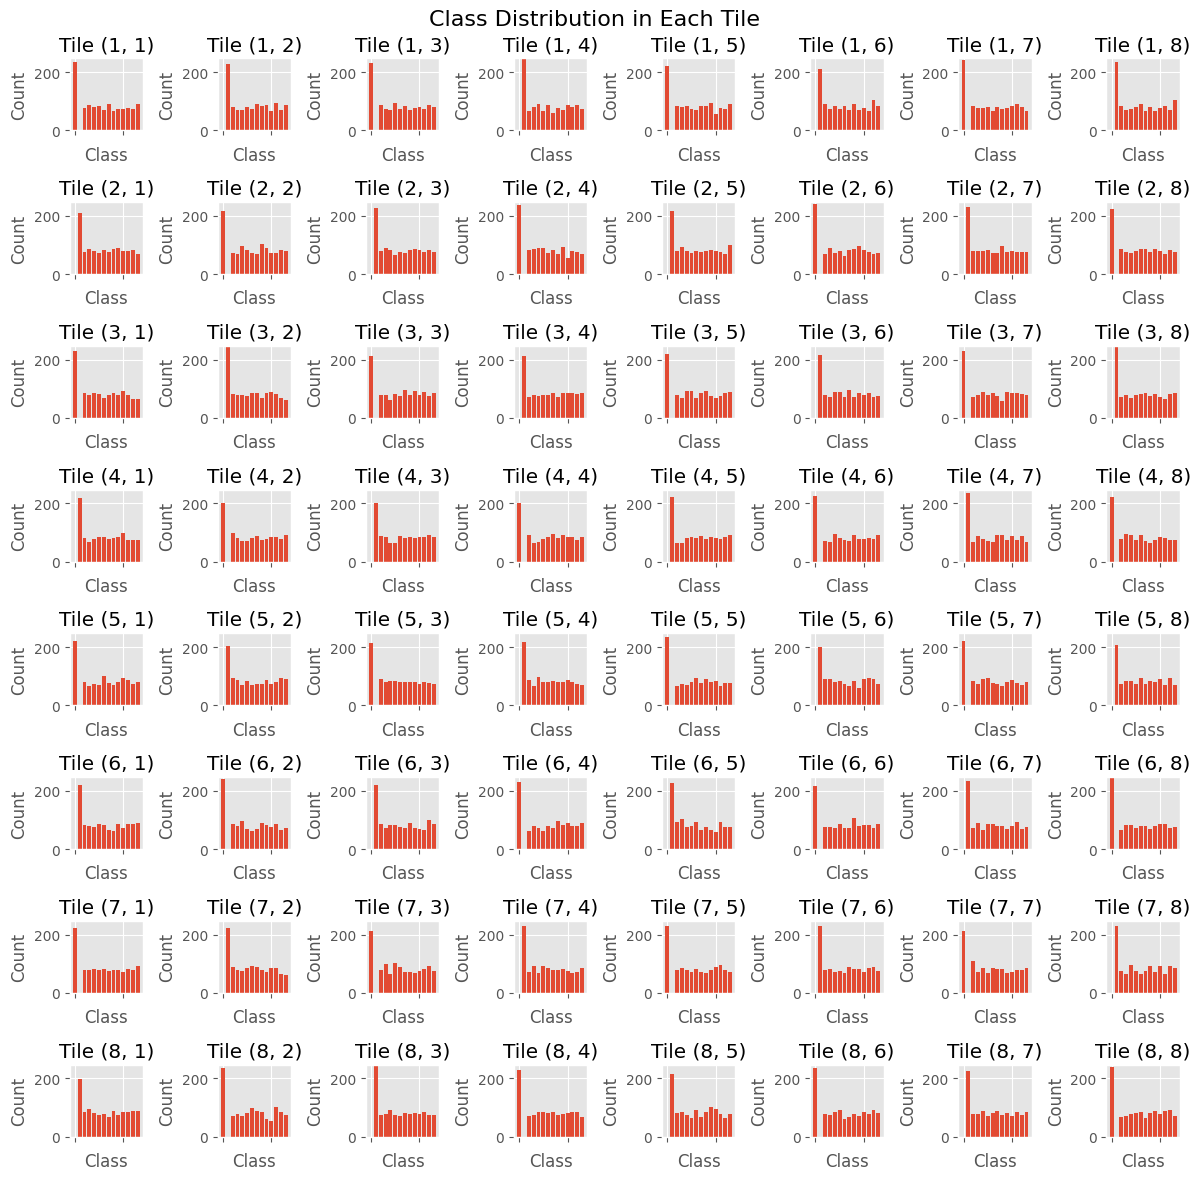

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Example 8x8x14 numpy array representing the class counts in each tile
class_counts = class_labels

# Create a figure with subplots for each tile
fig, axs = plt.subplots(8, 8, figsize=(12, 12))

# Iterate over each tile and plot the class distribution
for i in range(8):
    for j in range(8):
        axs[i, j].bar(range(14), class_counts[i, j])
        axs[i, j].set_ylim([0, np.max(class_counts)])
        #axs[i, j].set_xticks(range(14))
        axs[i, j].set_xticklabels([])  

        axs[i, j].set_title(f'Tile ({i+1}, {j+1})')
        axs[i, j].set_xlabel('Class')
        axs[i, j].set_ylabel('Count')

# Set overall plot title
plt.suptitle('Class Distribution in Each Tile', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
